**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1f2RV3yzZIqRoGpP9y-b45NgnivaIT-4q?usp=sharing)

2. Практика





Разберем обучение более подробно на примере готовой сети.

In [ ]:
# модуль для загрузки файлов в colab
from google.colab import files 

# Подключим tensorflow
import tensorflow as tf 

# Подключим токенайзер
from tensorflow.keras.preprocessing.text import Tokenizer

# Используем метод для формирования последовательностей одинаковой длины
from tensorflow.keras.preprocessing.sequence import pad_sequences 

# Загружаем абстрактный класс базовой модели сети от кераса
from tensorflow.keras.models import Model 

# Подключим необходимые слои
from tensorflow.keras.layers import Dense, Embedding, GRU

# Подключим оптимайзер
from tensorflow.keras.optimizers import Adam 

# Подключим функцию потерь
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Подключим numpy - библиотеку для работы с массивами данных
import numpy as np 

# Подключим библиотеку для визуализации данных
import matplotlib.pyplot as plt 

# Подключим модуль для определения форматирования и местоположения делений на осях графиков
import matplotlib.ticker as ticker 

# Подключим модуль для разбивки данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split 

# Подключим модуль для работы с регулярными выражениями
import re 

# Подключим модуль для работы с временем
import time

# Подключим модуль для работы с операционной системой
import os 

import gdown

In [ ]:
# Скачаем датасетa из пар фраз на русском и английском языках 

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/advanced/l3/rus-eng.zip', None, quiet=True)

'rus-eng.zip'

Распакуем скачанные тексты и убедимся в появлении файла со словарем:

In [ ]:
!unzip -o rus-eng.zip 

Archive:  rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              


In [ ]:
# Проверим распакованные файлы
!ls

_about.txt  rus-eng.zip  rus.txt  sample_data


In [ ]:
# Определим переменную с именем файла с датасетом
path_to_file="rus.txt"

Определим функцию для подготовки предложений из словаря для обучения нейронной  сети. Добавим пробелы между словами и знаками препинаний, служебные символы заменим на пробелы, уберем пробелы в начале и конце фразы., добавим тег `< start >` в начало фразы, `< end >` в конец:

In [ ]:
def preprocess_sentence(phrases): # Функция принимает содержимое словаря

  # Разделяем пробелами слова и знаки препинания("А как насчет тебя? " -> "А как насчет тебя ? ") 
  phrases = re.sub(r"([?.!,;:])", r" \1 ", phrases) # r" \1 " берёт значения 1й группы в скобках; обрамляем указанные символы пробелами

  # Заменяем всё на пробелы, за исключением (a-zA-Zа-яёА-ЯЁ?.!,;:)
  phrases = re.sub(r"[^a-zA-Zа-яёА-ЯЁ?.!,;:]+", " ", phrases) 
  
  # Получаем строку без случайных лишних пробелов в конце фраз(rstrip удаляет с конца строки)
  phrases = phrases.rstrip().strip()      

  # Для нашей модели обозначим тегами начало и конец предложения  
  phrases = '<start> ' + phrases + ' <end>' 

  # Функция возвращает предобработанные фразы
  return phrases 

In [ ]:
# Покажем пример обработки фразц

print("Фразы после обработки функцией с т.з. пунктуации примут вид:") 
print(preprocess_sentence("What about you?"))                         # Выведем пример до обработки 
print(preprocess_sentence("А как насчет тебя?"))                      # И после

Фразы после обработки функцией с т.з. пунктуации примут вид:
<start> What about you ? <end>
<start> А как насчет тебя ? <end>


Перегоним фразы в датасет. Он представляет список пар из русского и английского предложения. Будем использовать только первые num_examples пар

Создадим функцию по формированию датасета. На вход принимает путь к файлу с датасетом и требуемый размер датасета. Читает файл построчно и на выходе формирует список пар фраз.

In [ ]:
# Функция создания датасета

def create_dataset(path,          # Путь к файлу
                   num_examples): # Необходимый размер датасета 

  # Открываем файл и разбиваем фразы на отдельные строчки
  lines = open(path, encoding='UTF-8').read().strip().split('\n')

  # В каждой строке словаря разделяем английскую фразу от русской, и пропускаем через функцию предобработки данных
  word_pairs = [[preprocess_sentence(phrases) for phrases in l.split('\t')[0:2]]  for l in lines[:num_examples]]

  # Вернем пары фраз в виде [по-английски, по-русски]
  return zip(*word_pairs)


In [ ]:
print("Взглянем на пример пары фраз на выходе функции:")

english, russian = create_dataset(path_to_file,40000) # Вызовем функцию для демонстрации
print(english[-1])                                    # Выведем последний элемент из списка английских фраз
print(russian[-1])                                    # Выведем последний элемент из списка русских фраз

Взглянем на пример пары фраз на выходе функции:
<start> Don t be too long . <end>
<start> Не тяните . <end>


Создадим функцию для получения максимальной длины фразы из списка. На вход принимает список фраз. Перебирает список, выбираем максимальное значение длины

In [ ]:
# Создадим мини-функцию, возвращающую максимальную длину тензора
def max_length(tensor): # Функция принимает на вход тензор(фразы в виде последовательности индексов)

  # Вернем значение максимальной длины его элемента 
  return max(len(t) for t in tensor) 

Функция преобразовывает тексты в последовательности индексов. 
Используем стандартный токенайзер из модуля Keras. На вход принимает текст, обучает на нем токенайзер. Переводит текст в токены. Отдает полученые токены и токенайзер

In [ ]:
def tokenize(language): # Функция принимает текст одного из языков

  language_tokenizer = Tokenizer(filters='')               # Вызываем класс Токенизатор, просим его не удалять символы, которые он удаляет по умолчанию
  language_tokenizer.fit_on_texts(language)                # "скармливаем" ему тексты для обработки и сборки словаря частотности
  tensor = language_tokenizer.texts_to_sequences(language) # Разбиваем текст фраз на последовательности индексов
  tensor = pad_sequences(tensor, padding='post')           # Делаем последовательности фиксированной длины, заполняя нулями более короткие фразы

  # Возвращаем последовательность индексов(назовем ее тензор) и токенизатор
  return tensor, language_tokenizer 

Функция формирующая готовый датасет. Получает на вход путь к файлу с текстами и необходимый размер готового датасета


In [ ]:
def load_dataset(path,               # Путь к файлу с текстами
                 num_examples=None): # Необходимый объем датасета

    # Из исходного текста делаем датасет пар фраз, причём входным языком для сети сделаем русский
    targ_language, inp_language = create_dataset(path, num_examples)

    # Разбиваем текст на последовательность индексов(назовем ее тензор)
    input_tensor, inp_language_tokenizer = tokenize(inp_language)    # Формируем тензоры и токенизатор для русского языка
    target_tensor, targ_language_tokenizer = tokenize(targ_language) # Формируем тензоры и токенизатор для английского языка

    # Функция вернёт: тензор для русского языка, для английского языка; токенизаторы для русского и английского языков
    return input_tensor, target_tensor, inp_language_tokenizer, targ_language_tokenizer

Формируем датасет заданного объема - 40000 (в зависимости от приоритета скорости либо качества обучения), используем ранее написанные функции:


In [ ]:
num_examples = 40000 # Выберем 40 тысяч строк(всего в базе около 360тысяч строк, в каждой пара фраз)

input_tensor, target_tensor, inp_language_tokenizer, targ_language_tokenizer = load_dataset(path_to_file, num_examples)

# Вычислим максимальные длины тензоров для английского и русского языков, используя ранее заданную функцию
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

# Создаем тренировочную и тестовую выборки по формуле 80/20
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

Создадим вспомогательную функцию для вывода слова фразы и его индекса. На вход подаются токенайзер и фраза:

In [ ]:
# Визуализируем собранные данные

def convert(language_tokenizer,  # Токенайзер
            tensor):             # Список индексов слов
            
  #  Цикл по токенам во фразе
  for t in tensor:  
    if t!=0:                                                        # Если токен не 0. Т.е. не мусор в конце фразы
      print ("%d ----> %s" % (t, language_tokenizer.index_word[t])) # Выводи токен и соответствующее слово



Посмотрим на примеры
В первом блоке выведем русскую фразу и ее токен
Во втором агнлийскую.

Далее выводим статистику по датасету

In [ ]:
print ("Фраза на русском языке; соответствие индекса и слова")   
convert(inp_language_tokenizer, input_tensor_train[0])           # Выведем нулевую пару из русского датасета
print ()    

print ("Фраза на английском языке; соответствие индекса и слова")
convert(targ_language_tokenizer, target_tensor_train[0])         # Выведем нулевую пару из агнлийского датасета
print ()   
                                                      
print("Рус.яз. тренировочная: " , len(input_tensor_train), "фраз; ", "Анг.яз. тренировочная: ", len(target_tensor_train), "фраз")# Выведем статистику по обучающей выборке
print("Рус.яз. тестовая: ", len(input_tensor_val), "фраз; ", "Анг.яз. тестовая: ", len(target_tensor_val), "фраз")               # Выведем статистику по тестовой выборке

Фраза на русском языке; соответствие индекса и слова
1 ----> <start>
9 ----> ты
740 ----> посмотрел
22 ----> на
14 ----> меня
3 ----> .
2 ----> <end>

Фраза на английском языке; соответствие индекса и слова
1 ----> <start>
6 ----> you
291 ----> looked
75 ----> at
16 ----> me
3 ----> .
2 ----> <end>

Рус.яз. тренировочная:  32000 фраз;  Анг.яз. тренировочная:  32000 фраз
Рус.яз. тестовая:  8000 фраз;  Анг.яз. тестовая:  8000 фраз


Создаем `tf.data` датасет (Раздел `tf.data.Dataset API` предлагает построить готовый конвейер для обучения моделей)


In [ ]:
# Определим постоянные 

BUFFER_SIZE = len(input_tensor_train)                     # Укажем что случайно сэмплировать будем по всей длине обучающейся выборки
BATCH_SIZE = 256                                          # Указываем размер батча
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE     # Укажем количество шагов в одной эпохе
embedding_dim = 256                                       # Размерность эмбеддинга, векторного пространства
units = 1024                                              # Задаем размер слоя(количество нейронов в слое) 

In [ ]:
# Задаем размер русского словаря
vocab_inp_size = len(inp_language_tokenizer.word_index)+1 

# Задаем размер английского словаря
vocab_tar_size = len(targ_language_tokenizer.word_index)+1 

# Создаём датасет из массивов Numpy(рус и анг тренировочные фразы) со случайной подачей тренировочных сэмплов в процессе обучения
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)

# Передаем в датасет размер батча и указываем, что если в тренировке последний батч окажется неполным, то опустим его
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)


In [ ]:
# Посмотрим на форму примеров полученных батчей

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([256, 12]), TensorShape([256, 9]))

Вспомним нашу схему - сеть состоит их кодера, декодера и блока attention.

Давайте начнем оформлять кодер в виде класса. В этом примере кодер состоит из блоков `Embedding` и `GRU`. Обратим внимание на `return_sequences=True`, `return_state=True` - мы требуем состояния кодера на каждом шаге работы. 

На вход принимает фразу для перевода и начальное состояние. Отдает выход GRU и вектор скрытых состояний

In [ ]:
class Encoder(Model):

  # Конструктор класса 
  def __init__(self, 
               vocab_size,    # Размер словаря
               embedding_dim, # Размер пространсва эмбеддинга
               enc_units,     # Число нейронов в GRU
               batch_sz):     # Размер батча

    super(Encoder, self).__init__()                                   # Даем возможность использовать и исполнять методы класса-родителя в классе потомке 
    self.batch_sz = batch_sz                                          # Атрибут возвращает размер батча
    self.enc_units = enc_units                                        # Атрибут возвращает размер слоя в кодировщике
    self.embedding = Embedding(vocab_size, embedding_dim)             # Атрибут эмбеддинга - слой Кераса с размером словаря на входе и с dim=256

    # Реккурентной сетью выберем GRU, указываем размер слоя, вывод из слоя в виде последовательностей, 
    # и метод инициализации весов 'glorot_uniform'(или метод Ксавьера) для упрощения прохождения сигнала при распростр-ии ошибки
    self.gru = GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

  # Метод принимает входную фразу и начальное состояние
  def call(self, 
           x,       # Входная фраза
           hidden): # Начальное энкодера
    x = self.embedding(x) # входящие тензоры преобразовываются в эмбеддинг
    output, state = self.gru(x, initial_state = hidden) #затем пропускаются через GRU и получаем выход + новое состояние

    # Выход сети GRU и состояние на выходе
    return output, state 

  # Создаем метод инициализации состояний на скрытых слоях
  def initialize_hidden_state(self):

    # Вернем тензор из нулей размер батча на размер слоя, итсполбьзуем как начальное состояние энкодера
    return tf.zeros((self.batch_sz, self.enc_units)) 

Создаем экземпляр класса Encoder. Используем далее как готовый модуль при построении модели сети

In [ ]:
# Создадим модель кодировщика по уже заданным параметрам 
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

In [ ]:
# Подадим в качестве примера какой-то сэмпл(Тензор[64, 12]) на вход Encoder'у и визуализируем, что получим
sample_hidden = encoder.initialize_hidden_state() #инициализируем начальное скрытое состояние

# Даем Encoder'у сэмпл и начальное состояние, и получим выход из сети GRU и состояние на выходе (вызывается метод call класса Encoder)
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Размеры выхода из кодировщика: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Размеры скрытого состояния: (batch size, units) {}'.format(sample_hidden.shape))

Размеры выхода из кодировщика: (batch size, sequence length, units) (256, 12, 1024)
Размеры скрытого состояния: (batch size, units) (256, 1024)


Создадим класс модуля `attenton`, как предписывал Bahdanau. Разбор работы данного модуля мы прошли чуть ранее. На входе состояния кодера `hidden_state` и `values` - выход предыдущего декодера с предыдущего шага. На выходе вектор контекста и веса `attention`:

In [ ]:
class BahdanauAttention(Model): # Название класса именем создателя механизма Дмитрия Богданова(Bahdanau)

  # Создаем конструктор класса
  def __init__(self, 
               units):                        # Число нейронов 

    super(BahdanauAttention, self).__init__() # Даем возможность использовать и исполнять методы класса-родителя в классе потомке
    self.W1 = Dense(units)                    # Создаем Dense с заданным числом нейронов
    self.W2 = Dense(units)                    # Создаем Dense с заданным числом нейронов
    self.V =  Dense(1)                        # Создаем Dense с числом нейронов =1

  # Метод принимает состояние и выход энкодера ----------------------------------
  
  def call(self, 
           hidden_state, # Состояние энкодера
           values):      # Выход энкодера
    # Форма состояния на скрытом слое (batch_size, hidden size)
    # Форму состояния на каждом такте увеличим до (batch_size, 1, hidden size)
    # Добавляем это для того, чтобы получить оценку
    hidden_with_time_axis = tf.expand_dims(hidden_state, 1)

    # Форма оценки score (размер батча, макс.длина слов на входе, 1), однёрка в конце, чтобы применить self.V
    # До применения self.V оценка была бы (размер батча, макс.длина слов на входе, количество нейронов в слое)
    score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

    # К полученной оценке применим Софтмакс, который покажет вероятность полезности от 0 до 1 для каждого слова в фразе для декодера
    # Форма оценки score - (размер батча, макс.длина слов на входе, 1); Софтмакс применяем к оси "макс.длина слов"
    attention_weights = tf.nn.softmax(score, axis=1)

    # Построим вектор контекста 
    context_vector = attention_weights * values # Веса внимания перемножим со значениями(выхода из кодировщика)
    # Сумму также применяем по оси "макс.длина слов на входе"
    context_vector = tf.reduce_sum(context_vector, axis=1) # Размеры вектора контекста после суммирования будут (размер батча, размер слоя)

    # Возвращает вектор контекста и веса внимания
    return context_vector, attention_weights


Создадим экземпляр класса BahdanauAttention. Здесь 10 - число нейронов в первом dense слое

In [ ]:
# Проверим, как работает слой
attention_layer = BahdanauAttention(10)

# Подадим на вход слою внимания выход из Encodera и его состояние, и получим значение и веса внимания
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Размеры значения внимания: (размер батча, размер слоя) {}".format(attention_result.shape))
print("Размеры весов внимания: (размер батча, длина последовательности, 1) {}".format(attention_weights.shape))

Размеры значения внимания: (размер батча, размер слоя) (256, 1024)
Размеры весов внимания: (размер батча, длина последовательности, 1) (256, 12, 1)


Создаем класс декодера с attention. Декодер принимает обущающую фразу, прогоняет через embedding. Далее склеивает с вектором контента и подает на GRU.
На выходе dense слой с числом нейронов равному размеру словаря.

In [ ]:
class Decoder(Model):

  # Создадим конструктор класса
  def __init__(self,   
               vocab_size,    # Размер словаря
               embedding_dim, # Размерность пространства эмбеддинга
               dec_units,     # Число нейронов в GRU
               batch_sz):     # Размер батча
    super(Decoder, self).__init__()                       # Даем возможность использовать и исполнять методы класса-родителя в классе потомке 
    self.batch_sz = batch_sz                              # Атрибут возвращает размер батча
    self.dec_units = dec_units                            # Атрибут возвращает размер слоя в декодере(кол-во нейронов)
    self.embedding = Embedding(vocab_size, embedding_dim) # Атрибут эмбеддинга - слой Кераса с размером словаря на входе и (dim=256) на выходе

    # Реккурентной сетью выберем GRU, указываем размер слоя, вывод из слоя в виде последовательностей, 
    # и метод инициализации весов 'glorot_uniform'(или метод Ксавьера) для упрощения прохождения сигнала при распростр-ии ошибки    
    self.gru = GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

    self.fc = Dense(vocab_size) # Атрибут вызовет полносвязный слой с размером словаря

    self.attention = BahdanauAttention(self.dec_units) #атрибут подключит механизм внимания, описанный ранее


  def call(self, 
           x,           # Начальный токен
           hidden,      # Состояние  энкодера
           enc_output): # Выход энкодера

    # Enc_output размеры (batch_size, max_length, hidden_size - размер батча, макс.длина фраз, разм.скр.слоя)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # Входящий тензор слова пропускаем через эмбеддинг (получаем размеры batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # Дальше конкатенируем с вектором контекста (получаем размеры batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # Сконкатенированный вектор передаем  в GRU и получаем выход с декодера и состояние
    output, state = self.gru(x)

    # Output размеры (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # Пропускаем через полносвязный слой
    x = self.fc(output) #output размеры (batch_size, vocab)

    # Вернем выходную фразу, вектор состояния, веса внимания
    return x, state, attention_weights

In [ ]:
# Проверим работу декодера, подав на вход случайный массив с нужной размерностью
# Создали декодер с параметрами(размер анг.словаря, размерность эмбеддинга, кол-во нейронов, размер батча)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

# Подаём на вход случайный массив с нужной размерностью, состояние и выход с кодировщика
sample_decoder_output, _, _ = decoder(tf.random.uniform((256, 1)), sample_hidden, sample_output)
print ('Размер выхода с декодера: (размер батча, размер словаря) {}'.format(sample_decoder_output.shape))

Размер выхода с декодера: (размер батча, размер словаря) (256, 4271)


In [ ]:
# Выбираем оптимайзер Adam
optimizer = Adam() 

Наша функция потерь называется  `loss_function` - сначала она уберет из расчетов нулевые элементы в истинной и предсказанной фразе. 

Длина фразы может быть меньше максимально допустимой или фраза может быть сформирована не полностью. Просто не будем учитывать мусор в конце фразы.

Далее применим стандартную для Kerasa функцию потерь  SparseCategoricalCrossentropy. По сравнению CategoricalCrossentropy работает также, но позволяет нам не хранить слова в виде OneHotEncoding, что существенно экономить память.

На выходе получаем среднее значение потерь:

In [ ]:
# Используем SparseCategoricalCrossentropy, к-я может работать с некатегориальными лейблами
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none') # Выбираем функцию потерь

def loss_function(real, pred):                       # Запишем функцию потерь, на вход подаем фактический и предсказанный результат
  mask = tf.math.logical_not(tf.math.equal(real, 0)) # Найдем маску, которая уберет нулевые значения индексов в конце фразы
  loss_ = loss_object(real, pred)                    # Фактические и предсказанные результаты передаем в SparseCategoricalCrossentropy и получаем ошибку
  mask = tf.cast(mask, dtype=loss_.dtype)            # Согласуем тип маски с типом потерь
  loss_ *= mask                                      # Накидываем "маску" которая оставит для работы ненулевые значения
  
  # Вернем reduce_mean - среднее любого выбранного тензора
  return tf.reduce_mean(loss_)

In [ ]:
# Сохраняем процесс обучения модели чекпоинтами тензорфлоу

checkpoint_dir = './training_checkpoints'                                               # Даем ссылку на директорию
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")                                # Добавляем префикс "ckpt"
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder) # Сохраняем состояния/показатели оптимизатора и моделей

Создадим функцию для обучения модели. На входе - исходная фраза, конечная фраза, начальное состояния кодера. Подаем сразу батчем. На выходе потери на этом батче

In [ ]:
@tf.function
def train_step(inp,         # Входная фраза
               targ,        # Точный перевод
               enc_hidden): # Состояния энкодера

  # Создаем переменную, в которую будем записывать ошибку
  loss = 0                             

  # Все операции по вычислению градиента записываются на ленту(tape) и мы получаем к ним доступ
  with tf.GradientTape() as tape:

    # Передаем тензор и начальное состояние в кодировщик и получим выход и состояние на выходе
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    # Передадим это состояние декодеру
    dec_hidden = enc_hidden

    # Передаем в качестве входа в декодер индекс токена "<start>"
    dec_input = tf.expand_dims([targ_language_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # Техника "Teacher forcing" - подаем предыдущее выходное слово на вход следущего в декодере. Targ.shape[64, 9]

    for t in range(1, targ.shape[1]): #для каждого слова из английской фразы

      # Передаем в обработку декодеру начальный токен, состояние на выходе из кодера, и выход из кодера
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output) # Получаем от декодера предсказание и обновленное состояние

      # Обновляем ошибку для текущих предсказаний
      loss += loss_function(targ[:, t], predictions)

      # Используем "Teacher forcing"
      dec_input = tf.expand_dims(targ[:, t], 1)

  # Получаем ошибку на батче . Targ.shape[64, 9]. Делим на 9
  batch_loss = (loss / int(targ.shape[1])) 

  # Создаем список переменных, для которых TensorFlow будет вычислять градиенты
  variables = encoder.trainable_variables + decoder.trainable_variables # создаем переменные, для которых TensorFlow будет вычислять градиенты

  # Отслеживаем градиент
  gradients = tape.gradient(loss, variables)

  # Корректируем веса
  optimizer.apply_gradients(zip(gradients, variables))

  # Функция обучения вернет ошибку на батче
  return batch_loss

Обучаем сеть. 30 эпох. На каждой эпохе прогоняем весь набор данных через функцию обучения. Считаем лоссы. Сохраняем статистику каждые 10 эпох

In [ ]:
EPOCHS = 30 # устанавливаем количество эпох

for epoch in range(EPOCHS): # Цикл по каждой эпохе
  start = time.time() # Запомним время начала эпохи

  progbar = tf.keras.utils.Progbar(target=steps_per_epoch, stateful_metrics=[
                                     'batch_loss'], unit_name='batch')        # Создадим индикатор прогресс обучения

  enc_hidden = encoder.initialize_hidden_state() # Задаем начальное состояние на скрытом слое encodera 
  total_loss = 0                                 # Начальное значение итоговой ошибки

  # Для батча, входного и выходного тензора на каждом шаге эпохи
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden) # Передадим в функцию тензоры и состояние в кодировщике, обучим и получим ошибку на батче
    total_loss += batch_loss                       # Добавим ее в итоговую ошибку
    progbar.update(                                # Обновим состояние индикатора обучения
            batch + 1, values=[('batch_loss', batch_loss)])


  # Каждые 10 эпох будем сохранять чекпоинты
  if (epoch + 1) % 10 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  # Выведем показатели после каждой эпохи
  print('Эпоха {} Ошибка {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch)) # Выведем номер эпохи и потери
  print('Время на 1 эпоху {} сек'.format(round(time.time() - start), 1))          # Выведем длительность обучения этой эпохи

125/125 [==============================] - 27s 121ms/batch - batch_loss: 1.9272
Эпоха 1 Ошибка 2.4461
Время на 1 эпоху 27 сек
125/125 [==============================] - 15s 121ms/batch - batch_loss: 1.4900
Эпоха 2 Ошибка 1.6846
Время на 1 эпоху 15 сек
125/125 [==============================] - 15s 122ms/batch - batch_loss: 1.3640
Эпоха 3 Ошибка 1.3813
Время на 1 эпоху 15 сек
125/125 [==============================] - 16s 124ms/batch - batch_loss: 1.0486
Эпоха 4 Ошибка 1.1469
Время на 1 эпоху 20 сек
125/125 [==============================] - 16s 125ms/batch - batch_loss: 0.8416
Эпоха 5 Ошибка 0.9428
Время на 1 эпоху 16 сек
125/125 [==============================] - 16s 127ms/batch - batch_loss: 0.7352
Эпоха 6 Ошибка 0.7552
Время на 1 эпоху 16 сек
125/125 [==============================] - 16s 128ms/batch - batch_loss: 0.5982
Эпоха 7 Ошибка 0.5893
Время на 1 эпоху 16 сек
125/125 [==============================] - 16s 128ms/batch - batch_loss: 0.4578
Эпоха 8 Ошибка 0.4502
Время на 1 эпоху

Данная функция собирает модель кодера, декодера и attention для работы в режиме перевода (предсказания).

На входе переводимое русское предложение, на выходе его английский перевод

In [ ]:
def evaluate(sentence):

    # Создаем начальные настройки графика внимания
    attention_plot = np.zeros((max_length_targ, max_length_inp)) 
    
    # Предобрабатываем предложение
    sentence = preprocess_sentence(sentence) 

    inputs = [inp_language_tokenizer.word_index[i] for i in sentence.split(' ')]   # Преобразовываем в послед-ть индексов
    inputs = pad_sequences([inputs], maxlen=max_length_inp, padding='post')        # Делаем паддинг
    inputs = tf.convert_to_tensor(inputs)                                          # Конвертируем в тф тензор

    result = ''                                                                    # Сюда запишем результат

    hidden = [tf.zeros((1, units))]                                                # Задаем начальное состояние
    enc_out, enc_hidden = encoder(inputs, hidden)                                  # Передаем его и входной тензор и получаем выход с кодера и состояние

    dec_hidden = enc_hidden                                                        # Состояние кодера передаем в декодер
    dec_input = tf.expand_dims([targ_language_tokenizer.word_index['<start>']], 0) # Передаем на вход декодеру <start> в виде индекса

    for t in range(max_length_targ):                                               # Идем по макс.длине фраз выходного языка(анг)
        # Прогоняем через декодер входящий тензор, состояние с выхода кодера, выход с кодера
        # Получаем результат предсказания, обновленное состояние, и веса внимания
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # Сохраняем веса внимания для графика
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        # Аргмаксом вытаскиваем предсказанное слово
        predicted_id = tf.argmax(predictions[0]).numpy()

        # Результат конвертируем из индекса в слово и сохраняем в result = ''
        result += targ_language_tokenizer.index_word[predicted_id] + ' '

        # Если предсказанное слово - <end>, то останавливаемся, возвращаем результаты, выводим на графике
        if targ_language_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # Педсказанное значение подается обратно в модель
        dec_input = tf.expand_dims([predicted_id], 0)

    # Вернем перевод, входную фразу и веса внимания
    return result, sentence, attention_plot

Нам интересно как связаны слова в исходной фразе и в ее переведе. Функция отрисовывает веса внимания в виде 2D матрицы, соотносит каждую пару  слов  ее весом  

In [ ]:
def plot_attention(attention,           # Веса внимания
                   sentence,            # Исходная фраза
                   predicted_sentence): # Предсказаные перевод
  
    fig = plt.figure(figsize=(10,10))                                   # Зададим размер 
    ax = fig.add_subplot(1, 1, 1)                                       # Добавим 1 картинку
    ax.matshow(attention, cmap='viridis')                               # Нарисуем 2d матрицу
    fontdict = {'fontsize': 14}                                         # Зададим размер надписей
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90) # Добавим надпись по горизонтальной оси
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)    # Добавим надпись по вертикальной оси
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))               # Зададим форматирование делений на осях графиков
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))               # Зададим форматирование делений на осях графиков
    plt.show()                                                          # Отрисуем изображение

Соберем написанные ранее функции вместе. Будем переводить фразы и строить матрицы внимания(attention)  - смотреть связи слов в предложении

Создадим функцию для перевода фраз с визуализацией матрицы внимания

In [ ]:
def translate(sentence): # Функция принимает предложение и выводит результат с визуализацией
    result, sentence, attention_plot = evaluate(sentence)  # Отдадим фразу. Получим перевод, входную фразу,  веса внимания

    print('Входящая фраза: %s' % (sentence))          # Выведем входную фразу 
    print('Предсказанный перевод: {}'.format(result)) # Выведем полученный перевод

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))] # Возьмем весы внимания, только для слов во фразах. Хвосты не смотрим
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))              # Выведем веса внимания

In [ ]:
# Воспроизведём последний сохранённый чекпоинт
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

И, наконец, переведём предложение и выведем визуализацию

Входящая фраза: <start> давайте дружить <end>
Предсказанный перевод: let s glad . <end> 


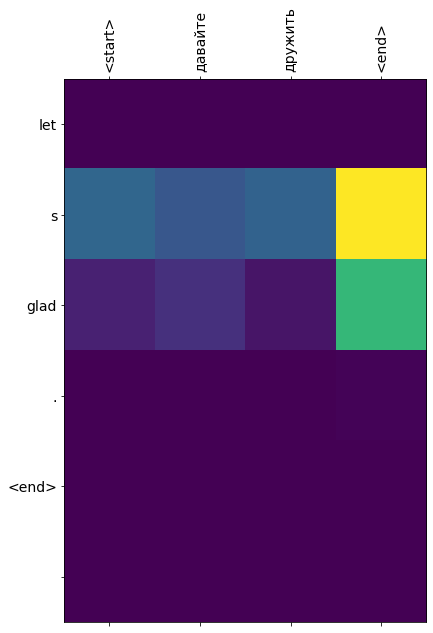

In [ ]:
translate('давайте дружить')

Входящая фраза: <start> у тебя всё хорошо <end>
Предсказанный перевод: you re all you . <end> 


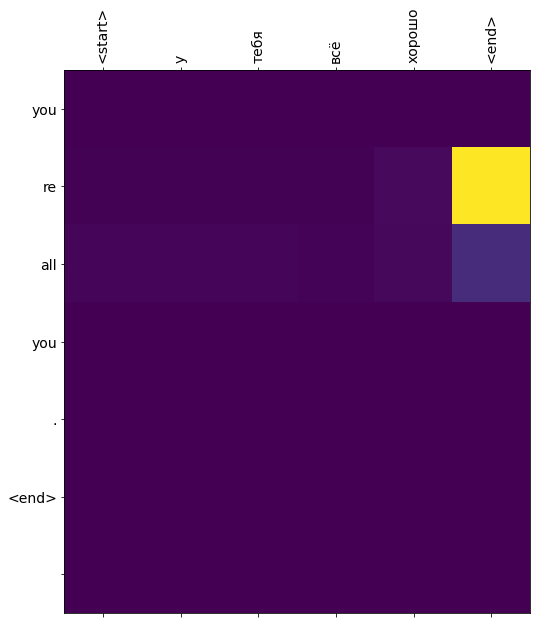

In [ ]:
translate('у тебя всё хорошо')

Входящая фраза: <start> у тебя всё хорошо ? <end>
Предсказанный перевод: do you have it ? <end> 


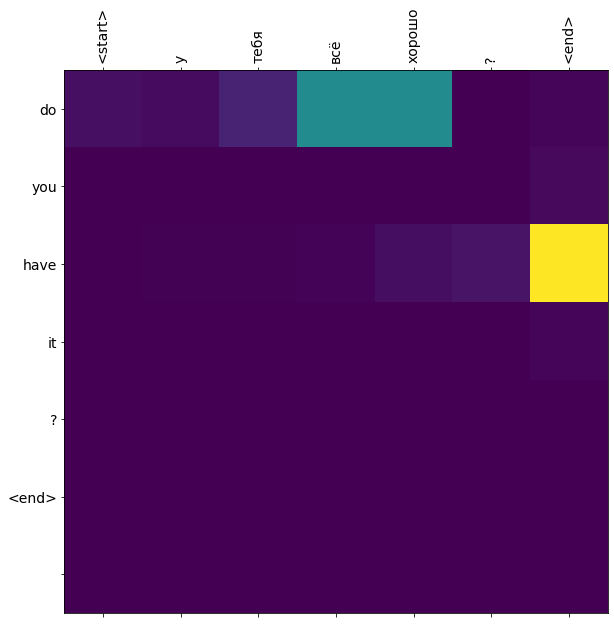

In [ ]:
translate('у тебя всё хорошо?')

Что можно сказать. Как переводчик сеть не очень. Но связи слов в предложениях уже находит

**Содержание темы**


1. [Теория](https://colab.research.google.com/drive/1f2RV3yzZIqRoGpP9y-b45NgnivaIT-4q?usp=sharing)

2. Практика



